In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 500
batch_size = 128
F_MAP_1 = 95
F_MAP_2 = 100
DROPOUT = 0.9


seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
with open('data_batch_1', 'rb') as db:
    try:
        train_samples = pickle.load(db)
    except UnicodeDecodeError:  #python 3.x
        db.seek(0)
        train_samples = pickle.load(db, encoding='latin1')

trainX, trainY = train_samples['data'], train_samples['labels']

trainX = np.array(trainX, dtype=np.float32)
trainY = np.array(trainY, dtype=np.int32)
    
trainY_ = np.zeros([trainY.shape[0], NUM_CLASSES])
trainY_[np.arange(trainY.shape[0]), trainY-1] = 1

print(trainX.shape, trainY_.shape)



(10000, 3072) (10000, 10)


In [4]:
with open('test_batch_trim', 'rb') as tb:
    try:
        test_samples = pickle.load(tb)
    except UnicodeDecodeError:  #python 3.x
        tb.seek(0)
        test_samples = pickle.load(tb, encoding='latin1')
        
testX, testY = test_samples['data'], test_samples['labels']

testX = np.array(testX, dtype=np.float32)
testY = np.array(testY, dtype=np.int32)
    
testY_ = np.zeros([testY.shape[0], NUM_CLASSES])
testY_[np.arange(testY.shape[0]), testY-1] = 1

print(testX.shape, testY_.shape)

(2000, 3072) (2000, 10)


In [5]:
trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)

 # Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

images = x
images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    
#Conv 1 -- maps one RGB image (3x32x32) to 50 feature maps (50x24x24), pool to (50x12x12)
W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, F_MAP_1], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
b1 = tf.Variable(tf.zeros([F_MAP_1]), name='biases_1')

conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

#Conv 2 -- maps 50 feature maps (50x12x12) to 60 (60x8x8), pool to (60x4x4)
W2 = tf.Variable(tf.truncated_normal([5, 5, F_MAP_1, F_MAP_2], stddev=1.0/np.sqrt(NUM_CHANNELS*5*5)), name='weights_2')
b2 = tf.Variable(tf.zeros([F_MAP_2]), name='biases_2')

conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1,1,1,1,], padding='VALID')+ b2)
pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

#Fully Connected Layer -- maps 60 feature maps (60x4x4) to 300 features
pool_2_shape = pool_2.get_shape().as_list()
dim = pool_2_shape[1] * pool_2_shape[2] * pool_2_shape[3]
reshape = tf.reshape(pool_2, [-1, dim])

W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
b3 = tf.Variable(tf.zeros([300]), name='biases_3')

fcon = tf.nn.relu(tf.matmul(reshape, W3) + b3)
fcon = tf.nn.dropout(fcon, DROPOUT)

#Softmax
W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), name='weights_4')
b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')
logits = tf.matmul(fcon, W4) + b4

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#Using Adam Optimizer algorithm
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(trainX)
print(N)
idx = np.arange(N)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_acc = []
    training_loss = []
    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY_ = trainX[idx], trainY_[idx]
        
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step.run(feed_dict={x: trainX[start:end], y_: trainY_[start:end]})
            
        training_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY_}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY_}))

        print('epoch', e, 'entropy', training_loss[e], 'test accuracy', test_acc[e])
    

W1114 22:43:15.015123 11780 deprecation.py:506] From <ipython-input-5-a49ad72d085e>:33: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


10000
epoch 0 entropy 1.8112515 test accuracy 0.3385
epoch 1 entropy 1.7409129 test accuracy 0.3375
epoch 2 entropy 1.572073 test accuracy 0.398
epoch 3 entropy 1.5442438 test accuracy 0.4145
epoch 4 entropy 1.4391233 test accuracy 0.4615
epoch 5 entropy 1.3979877 test accuracy 0.3965
epoch 6 entropy 1.2986075 test accuracy 0.442
epoch 7 entropy 1.2933148 test accuracy 0.425
epoch 8 entropy 1.2463155 test accuracy 0.43
epoch 9 entropy 1.1358749 test accuracy 0.459
epoch 10 entropy 1.1178144 test accuracy 0.4145
epoch 11 entropy 1.028764 test accuracy 0.41
epoch 12 entropy 1.0032605 test accuracy 0.441
epoch 13 entropy 0.9056916 test accuracy 0.4445
epoch 14 entropy 0.7966229 test accuracy 0.461
epoch 15 entropy 0.76146024 test accuracy 0.4425
epoch 16 entropy 0.7137136 test accuracy 0.429
epoch 17 entropy 0.6438044 test accuracy 0.413
epoch 18 entropy 0.5794578 test accuracy 0.4185
epoch 19 entropy 0.5206458 test accuracy 0.4325
epoch 20 entropy 0.5061852 test accuracy 0.4045
epoch 21 

epoch 167 entropy 0.024978777 test accuracy 0.419
epoch 168 entropy 0.014938971 test accuracy 0.4215
epoch 169 entropy 0.03829044 test accuracy 0.404
epoch 170 entropy 0.027682148 test accuracy 0.4165
epoch 171 entropy 0.028920075 test accuracy 0.403
epoch 172 entropy 0.01911049 test accuracy 0.407
epoch 173 entropy 0.018144064 test accuracy 0.403
epoch 174 entropy 0.019749701 test accuracy 0.4225
epoch 175 entropy 0.009934327 test accuracy 0.4435
epoch 176 entropy 0.018021984 test accuracy 0.4025
epoch 177 entropy 0.02361084 test accuracy 0.4275
epoch 178 entropy 0.03556702 test accuracy 0.396
epoch 179 entropy 0.021034751 test accuracy 0.4175
epoch 180 entropy 0.0138186095 test accuracy 0.4265
epoch 181 entropy 0.026002146 test accuracy 0.4295
epoch 182 entropy 0.019748954 test accuracy 0.4005
epoch 183 entropy 0.042447016 test accuracy 0.4015
epoch 184 entropy 0.033086922 test accuracy 0.4115
epoch 185 entropy 0.034898277 test accuracy 0.408
epoch 186 entropy 0.019326298 test accura

epoch 331 entropy 0.045779347 test accuracy 0.427
epoch 332 entropy 0.020775177 test accuracy 0.407
epoch 333 entropy 0.026650531 test accuracy 0.3925
epoch 334 entropy 0.031663787 test accuracy 0.393
epoch 335 entropy 0.011232693 test accuracy 0.401
epoch 336 entropy 0.012127355 test accuracy 0.4115
epoch 337 entropy 0.0059324508 test accuracy 0.406
epoch 338 entropy 0.020850444 test accuracy 0.404
epoch 339 entropy 0.044595253 test accuracy 0.3955
epoch 340 entropy 0.017978504 test accuracy 0.387
epoch 341 entropy 0.010051467 test accuracy 0.418
epoch 342 entropy 0.012504158 test accuracy 0.3965
epoch 343 entropy 0.021611126 test accuracy 0.3965
epoch 344 entropy 0.028165247 test accuracy 0.383
epoch 345 entropy 0.026287585 test accuracy 0.3855
epoch 346 entropy 0.0195939 test accuracy 0.3835
epoch 347 entropy 0.018847043 test accuracy 0.401
epoch 348 entropy 0.020591583 test accuracy 0.3945
epoch 349 entropy 0.039437227 test accuracy 0.3845
epoch 350 entropy 0.026020175 test accurac

epoch 495 entropy 0.01643388 test accuracy 0.4085
epoch 496 entropy 0.016202081 test accuracy 0.398
epoch 497 entropy 0.020278754 test accuracy 0.3955
epoch 498 entropy 0.007971788 test accuracy 0.412
epoch 499 entropy 0.016385034 test accuracy 0.3975


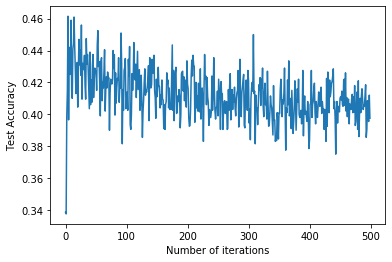

In [6]:
    plt.figure(1)
    plt.plot(range(epochs), test_acc)
    plt.ylabel('Test Accuracy')
    plt.xlabel('Number of iterations')
    plt.savefig('./A3d-Test_accuracy.png')

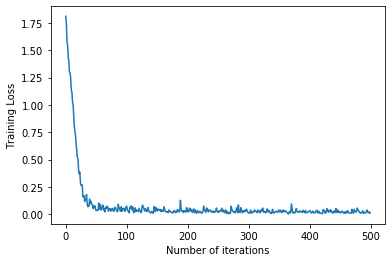

In [7]:
    plt.figure(2)
    plt.plot(range(epochs), training_loss)
    plt.xlabel('Number of iterations')
    plt.ylabel('Training Loss')
    plt.savefig('./A3d-Training_loss.png')